In [ ]:
# defining root location of the project on local system (change this to your own path after pulling)
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# set up plotting config
mpl.rcParams['mathtext.fontset'] = 'stix'  # or 'dejavusans', 'cm', 'custom'
mpl.rcParams['font.family'] = 'STIXGeneral'  # Matches STIX math font
# set tick font size
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
# set default fontsize
mpl.rcParams['font.size'] = 16

# function to convert hex color to rgb tuple
def hex2rgb(hex: str) -> tuple[float, float, float]:
    rbg = tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))
    return tuple([c/255 for c in rbg])


colorI, colorII, colorIII = hex2rgb('71A8C4'), hex2rgb('EACEBD'), hex2rgb('F8A17B')

# define root
ROOT = "/home/andreasstillits/coding/Leaves1D/"
%pwd

'/home/andreasstillits/coding/Leaves1D/figures/scripts'

### Helper functions

In [23]:
def map_data_values(df: pd.DataFrame, map: np.ndarray, vmin: float = 0.01, vmax: float = 100) -> np.ndarray:
    taus_data = df['tau'].to_numpy()
    gammas_data = df['gamma'].to_numpy()
    N_gamma, N_tau = map.shape 
    taus = np.exp(np.linspace(np.log(vmin), np.log(vmax), N_tau))
    gammas = np.exp(np.linspace(np.log(vmin), np.log(vmax), N_gamma))
    log_taus = np.log(taus)
    log_gammas = np.log(gammas)
    
    values = []
    for tau_data, gamma_data in zip(taus_data, gammas_data):
        # Handle out-of-bounds values by clipping to grid range via nearest neighbour
        if (tau_data <= taus[0]) or (tau_data >= taus[-1]) or (gamma_data <= gammas[0]) or (gamma_data >= gammas[-1]):
            idx_tau = int(np.argmin(np.abs(taus - tau_data)))
            idx_gamma = int(np.argmin(np.abs(gammas - gamma_data)))
            values.append(map[idx_gamma, idx_tau])
            continue

        # Work in log-space for interpolation weights
        log_tau_data = np.log(tau_data)
        log_gamma_data = np.log(gamma_data)

        # Find indices of the two neighbouring grid points in each direction (in log-space)
        idx_tau_upper = int(np.searchsorted(log_taus, log_tau_data, side="right"))
        idx_tau_lower = idx_tau_upper - 1
        idx_gamma_upper = int(np.searchsorted(log_gammas, log_gamma_data, side="right"))
        idx_gamma_lower = idx_gamma_upper - 1

        x0, x1 = log_taus[idx_tau_lower], log_taus[idx_tau_upper]
        y0, y1 = log_gammas[idx_gamma_lower], log_gammas[idx_gamma_upper]

        f00 = map[idx_gamma_lower, idx_tau_lower]
        f10 = map[idx_gamma_lower, idx_tau_upper]
        f01 = map[idx_gamma_upper, idx_tau_lower]
        f11 = map[idx_gamma_upper, idx_tau_upper]

        tx = (log_tau_data - x0) / (x1 - x0)
        ty = (log_gamma_data - y0) / (y1 - y0)

        value = (
            (1 - tx) * (1 - ty) * f00 +
            tx * (1 - ty) * f10 +
            (1 - tx) * ty * f01 +
            tx * ty * f11
)
        values.append(value)

    return np.array(values)
    
def std_layout(ax: plt.Axes, vmin: float = 0.01, vmax: float = 100, inset: bool = False) -> None:
    """Helper function to set standard plot settings for (tau,gamma) figures."""
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.plot([1, 1], [vmin, vmax], color="grey", linestyle="-.", zorder=2)
    ax.plot([vmin, vmax], [1, 1], color="grey", linestyle="-.", zorder=2)

    df = pd.read_csv(ROOT + "data/saved_data/Knauer2022_hypostomatous.csv", decimal=',', sep=';')
    dfMomayyeziW = pd.read_csv(ROOT + 'data/saved_data/Momayyezi2022_watered.csv', sep=';', decimal=',')
    dfMomayyeziDH = pd.read_csv(ROOT + 'data/saved_data/Momayyezi2022_dehydrated.csv', sep=';', decimal=',')

    markersize = 25 if not inset else 10

    ax.scatter(df['tau'], df['gamma'], color="darkblue", marker="o", zorder=3, label="Knauer et al.", s=markersize)
    ax.scatter(dfMomayyeziW['tau'], dfMomayyeziW['gamma'], color="darkgreen", marker="o", zorder=3, label="Momayyezi et al. (watered)", s=markersize)
    ax.scatter(dfMomayyeziDH['tau'], dfMomayyeziDH['gamma'], color="darkred", marker="o", zorder=3, label="Momayyezi et al. (dehydrated)", s=markersize)
    if not inset:
        ax.set_xlabel(r"Absorption balance $\tau$ []")
        ax.set_ylabel(r"Transport balance $\gamma$ []")
        # ax.legend(loc="upper left", fontsize=10)            

def std_histogram(ax: plt.Axes, xlabel: str = "Error (%)") -> None:
    ax.set_ylabel('Count')
    ax.set_xlabel(xlabel)
    ax.set_yscale('log')
    ax.legend(loc="upper right", fontsize=10)
    return

def describe_errors(errors: np.ndarray, *thresholds: float) -> None:
    print(f"Mean error: {np.mean(errors):.2f}%")
    print(f"Median error: {np.median(errors):.2f}%")
    print(f"Max error: {np.max(errors):.2f}%")
    print(f"Min error: {np.min(errors):.2f}%")
    for threshold in thresholds:
        print(f"Percentage of errors below {threshold}%: {100 * np.sum(errors < threshold)/len(errors):.2f}%")
    print("\n")

### Figure 2B+A

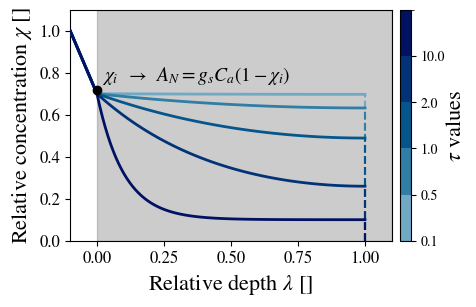

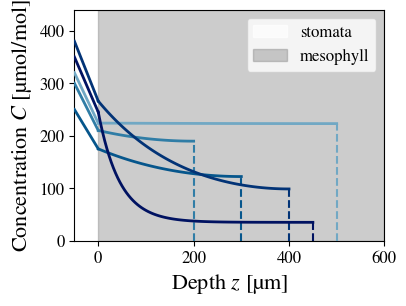

In [24]:
# define dimensionless parameters
chi_ = 0.1 # relative CO2 compensation point
sigma = 2 # coordination number gs/gm*
taus = np.array([0.1, 0.5, 1, 2, 10])
lambda_st = 0.1 # fractional epidermal layer thickness (typical value)

# define solutions according to Eqs. 2-6
chi = lambda x, tau: chi_ + (1-chi_)/(1 + 1/sigma)*(np.cosh(tau*(1-x)))/(np.cosh(tau))
chi_st = lambda x, tau: chi(0, tau) + (chi(0, tau) - 1)/lambda_st * x

# define domain lists
lambdas = np.linspace(0, 1, 100)
lambdas_st = np.linspace(-lambda_st, 0, 10)

# create plot of rescaled profiles (figure 2B)
fig, ax = plt.subplots(figsize=(5, 3))
colors = ['#001261', '#023376','#06568C', '#307DA6', '#71A8C4'][::-1]
stomata_color = 'white'
mesophyll_color = 'grey'

for tau, color in zip(taus, colors):
    chis = chi(lambdas, tau)
    ax.plot(lambdas_st, chi_st(lambdas_st, tau), color=color, linewidth=2, zorder=3)
    ax.plot(lambdas, chis, color=color,  linewidth=2, zorder=3)
    ax.plot([1, 1], [0, chis[-1]], color=color, linestyle='--')

ax.set_xlim(-lambda_st, 1.1)
ax.set_ylim(0, 1.1)
ax.set_xlabel(r'Relative depth $\lambda$ []')
ax.set_ylabel(r'Relative concentration $\chi$ []')
ax.fill_betweenx([0, 1.1], -lambda_st, 0, color=stomata_color, alpha=0.4, label='stomatal domain', zorder=0)
ax.fill_betweenx([0, 1.1], 0, 1.1, color=mesophyll_color, alpha=0.4, label='mesophyll domain', zorder=0)
ax.text(0.02, 0.76, r'$\chi_i \;\; \rightarrow \;\; A_N = g_s C_a(1-\chi_i) $', fontsize=14)
ax.plot(0, 0.72, 'ko', zorder=3)

# Make the colormap discrete using BoundaryNorm and a listed colormap
# Define discrete boundaries for each tau
bounds = np.append(taus, taus[-1] + (taus[-1] - taus[-2]))  # add an upper bound
# Create a discrete colormap using the same colors as used for the lines
discrete_cmap = ListedColormap(colors)
# Create a norm that maps values to the correct color bin
norm = BoundaryNorm(bounds, discrete_cmap.N)
# Add colorbar
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, boundaries=bounds, ticks=taus)
cbar.set_label(r'$\tau$ values', labelpad=1)
cbar.ax.tick_params(labelsize=10)
plt.savefig(ROOT + 'figures/vectorgraphics/figure2/figure2B.svg')
plt.savefig(ROOT + "figures/vectorgraphics/figure2/figure2B.png", dpi=300)
plt.show()

#_____________________________________________________

# create show-case profiles in literature units (figure 2A)

L_st = 50 # stomatal domain thickness in µm
# solutions in literature units
C = lambda x, ca, L, tau : ca*chi_ + (ca - ca*chi_)/(1 + 1/sigma)*(np.cosh(tau*(1-x/L)))/(np.cosh(tau))
C_st = lambda x, ca, L, tau : C(0, ca, L, tau) + (C(0, ca, L, tau) - ca)/L_st * x

fig, ax = plt.subplots(figsize=(4, 3))

# helper function to plot the profiles
def plot(Ca, L, tau, color):
    z = np.linspace(0, L, 100)
    z_st = np.linspace(-L_st, 0, 10)
    ax.plot(z, C(z, Ca, L, tau), color=color, linewidth=2, zorder=3)
    ax.plot(z_st, C_st(z_st, Ca, L, tau), color=color, linewidth=2, zorder=3)
    ax.plot([L, L], [0, C(L, Ca, L, tau)], color=color, linestyle='--', zorder=3)

               # Ca   L
combinations = [(320, 500), 
                (300, 200), 
                (250, 300), 
                (380, 400), 
                (350, 450)]

# plot example profiles
for comb, tau, color in zip(combinations, taus, colors):
    plot(comb[0], comb[1], tau, color)

ax.set_xlim(-L_st, 600)
ax.set_ylim(0, 440)
ax.set_xlabel(r'Depth $z$ [µm]')
ax.set_ylabel(r'Concentration $C$ [µmol/mol]')
ax.fill_betweenx([0, 440], -L_st, 0, color=stomata_color, alpha=0.7, label='stomata', zorder=0)
ax.fill_betweenx([0, 440], 0, 600, color=mesophyll_color, alpha=0.4, label='mesophyll', zorder=0)
ax.legend(fontsize=12)
plt.savefig(ROOT + 'figures/vectorgraphics/figure2/figure2A.svg')
plt.savefig(ROOT + "figures/vectorgraphics/figure2/figure2A.png", dpi=300)
plt.show()



### Figure 2D

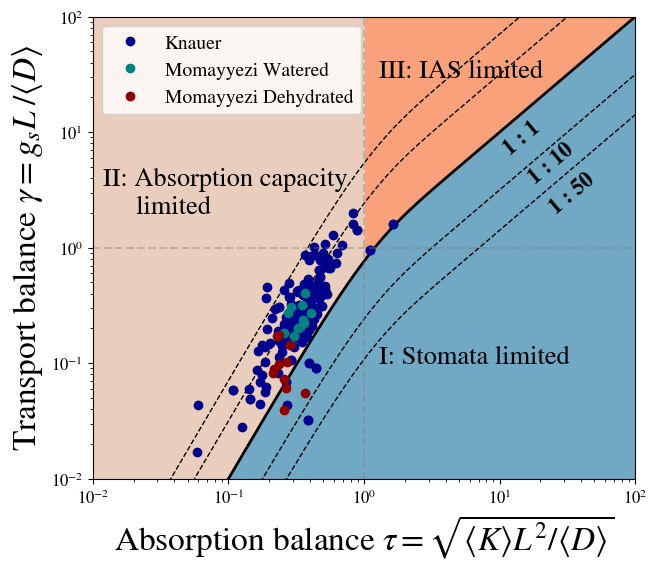

In [25]:
fig = plt.figure(figsize=(7, 6))

chi_ = 0.1
xmin, xmax = 0.01, 100
taus = np.exp(np.linspace(np.log(xmin), np.log(xmax), 400))
borders = lambda taus, sigma: sigma*taus*np.tanh(taus)

# COLORS
point_colors = ["darkblue", "teal", "darkred"]

# shading
plt.fill_between(taus, borders(taus, 1), xmin, color=colorI)
plt.fill_between(taus[taus <= 1], xmax, borders(taus[taus <= 1], 1), color=colorII)
plt.fill_between(taus[taus >= 1], xmax, borders(taus[taus >= 1], 1), color=colorIII)
# lines
plt.plot(taus, borders(taus, 1), color='black', linestyle='-', linewidth=2)
plt.plot(taus, borders(taus, np.sqrt(50)), color='black', linestyle='--', linewidth=1)
plt.plot(taus, borders(taus, np.sqrt(10)), color='black', linestyle='--', linewidth=1)
plt.plot(taus, borders(taus, 1/np.sqrt(10)), color='black', linestyle='--', linewidth=1)
plt.plot(taus, borders(taus, 1/np.sqrt(50)), color='black', linestyle='--', linewidth=1)
# annotate
plt.text(10, 6.5, '1 : 1', fontweight='bold', color='black', rotation=40)
plt.text(15.2, 3.6, '1 : 10', fontweight='bold', color='black', rotation=40)
plt.text(22, 2, '1 : 50', fontweight='bold', color='black', rotation=40)
# label the regions
plt.text(1.3, 0.1, r'I: Stomata limited', color='black', fontsize=19)
plt.text(0.012, 2, r'II: Absorption capacity'+'\n     limited', color='black', fontsize=19)
plt.text(1.3, 30, r'III: IAS limited', color='black', fontsize=19)

# load dfKnauer and dfMomayyezi to plot the data points
dfKnauer = pd.read_csv(ROOT + 'data/saved_data/Knauer2022_hypostomatous.csv', sep=';', decimal=',')
dfMomayyeziW = pd.read_csv(ROOT + 'data/saved_data/Momayyezi2022_watered.csv', sep=';', decimal=',')
dfMomayyeziDH = pd.read_csv(ROOT + 'data/saved_data/Momayyezi2022_dehydrated.csv', sep=';', decimal=',')

# plot data points 
for df, color, label in zip([dfKnauer, dfMomayyeziW, dfMomayyeziDH], point_colors, ['Knauer', 'Momayyezi Watered', 'Momayyezi Dehydrated']):
    plt.plot(df['tau'], df['gamma'], 'o', color=color, label=label)

plt.xlabel(r'Absorption balance $\tau = \sqrt{\langle K \rangle L^2 / \langle D \rangle}$', fontsize=24)
plt.ylabel(r'Transport balance $\gamma = g_s L \;/ \langle D \rangle$', fontsize=24)
plt.plot([1, 1], [xmin, xmax], color='grey', linestyle='--', alpha=0.4)
plt.plot([xmin, xmax], [1, 1],  color='grey', linestyle='--', alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.legend(fontsize=14)
plt.savefig(ROOT + 'figures/vectorgraphics/figure2/figure2D.svg')
plt.savefig(ROOT + 'figures/vectorgraphics/figure2/figure2D.png', dpi=300)
plt.show()


### Figure 2E

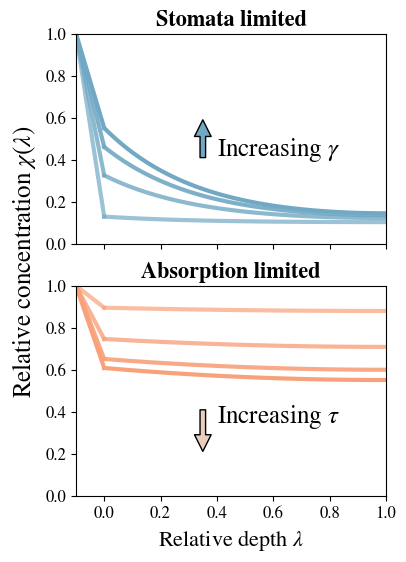

In [26]:
lambda_st = 0.1
lambdas = np.linspace(0, 1, 100)
chi = lambda x, tau, gamma, chi_=0.1: chi_ + (1-chi_)/(1 + tau*np.tanh(tau)/gamma)*(np.cosh(tau*(1-x)))/(np.cosh(tau))

stomata_lim_fig = []
tau, gammas = (3.0, [0.1, 1.0, 2, 3.0]) # tau, gammas
for gamma in gammas:
    stomata_lim_fig.append(chi(lambdas, tau, gamma))

absorption_lim_fig = []
gamma, taus = (0.3, [0.2, 0.35, 0.45, 0.5]) # gamma, taus
for tau in taus:
    absorption_lim_fig.append(chi(lambdas, tau, gamma))
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=True, sharey=True)
alphas = [0.7, 0.8, 0.9, 1.0]

def fill_subplot(ax, data, title, c, fs=16):
    for z, alpha in zip(data, alphas):
        ax.plot(lambdas, z, color=c, alpha = alpha, linewidth=3)
        ax.plot([-lambda_st, 0], [1, z[0]], color=c, alpha=alpha, linewidth=3)
    ax.set_title(title, fontsize=fs, weight='bold')
    ax.set_xlim(-lambda_st, 1)
    ax.set_ylim(0, 1)

fill_subplot(ax1, stomata_lim_fig, 'Stomata limited', c=colorI)
ax1.text(0.4, 0.42, r'Increasing $\gamma$', fontsize=18, color='black')
ax1.annotate('', xy=(0.35, 0.6), xytext=(0.35, 0.4), arrowprops=dict(facecolor=colorI, shrink=0.05))

fill_subplot(ax2, absorption_lim_fig, 'Absorption limited', c=colorIII)
ax2.text(0.4, 0.35, r'Increasing $\tau$', fontsize=18, color='black')
ax2.annotate('', xy=(0.35, 0.2), xytext=(0.35, 0.42), arrowprops=dict(facecolor=colorII, shrink=0.05))
ax2.set_xlabel(r'Relative depth $\lambda$', fontsize=16)
fig.supylabel(r'Relative concentration $\chi(\lambda)$', fontsize=18, x=-0.04)

plt.savefig(ROOT + 'figures/vectorgraphics/figure2/figure2E.svg')
plt.savefig(ROOT + 'figures/vectorgraphics/figure2/figure2E.png', dpi=300)
plt.show()

### Figure 2F

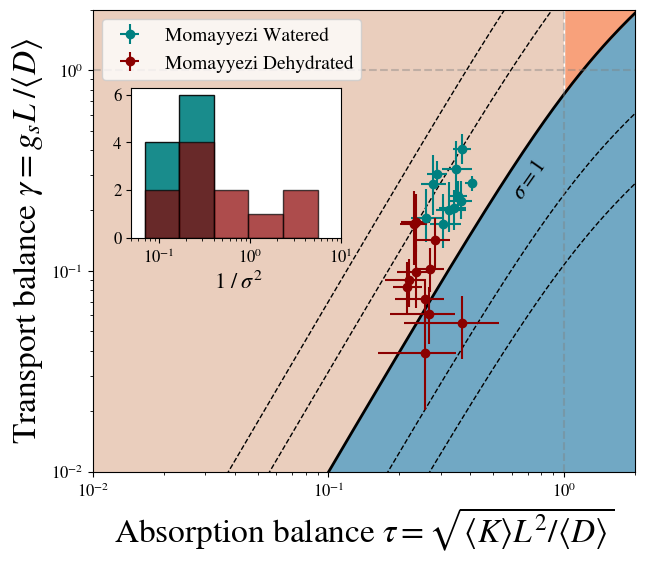

In [27]:
fig = plt.figure(figsize=(7, 6))
chi_ = 0.1
xmin, xmax = 0.01, 100
alpha = 0.6

taus = np.exp(np.linspace(np.log(xmin), np.log(xmax), 400))
borders = lambda taus, sigma: sigma*taus*np.tanh(taus)

# COLORS
point_colors = ["teal", "darkred"]

# shading
plt.fill_between(taus, borders(taus, 1), xmin, color=colorI)
plt.fill_between(taus[taus <= 1], xmax, borders(taus[taus <= 1], 1), color=colorII)
plt.fill_between(taus[taus >= 1], xmax, borders(taus[taus >= 1], 1), color=colorIII)
# lines
plt.plot(taus, borders(taus, 1), color='black', linestyle='-', linewidth=2)
plt.plot(taus, borders(taus, np.sqrt(50)), color='black', linestyle='--', linewidth=1)
plt.plot(taus, borders(taus, np.sqrt(10)), color='black', linestyle='--', linewidth=1)
plt.plot(taus, borders(taus, 1/np.sqrt(10)), color='black', linestyle='--', linewidth=1)
plt.plot(taus, borders(taus, 1/np.sqrt(50)), color='black', linestyle='--', linewidth=1)
plt.text(0.58, 0.23, r'$\sigma = 1$', color='black', fontweight='bold', rotation=55)

# load dfMomayyezi to plot the data points
dfMomayyeziW = pd.read_csv(ROOT + 'data/saved_data/Momayyezi2022_watered.csv', sep=';', decimal=',')
dfMomayyeziDH = pd.read_csv(ROOT + 'data/saved_data/Momayyezi2022_dehydrated.csv', sep=';', decimal=',')

# plot data points 
for df, color, label in zip([dfMomayyeziW, dfMomayyeziDH], point_colors, ['Momayyezi Watered', 'Momayyezi Dehydrated']):
    plt.errorbar(df['tau'], df['gamma'], xerr=[df['dtau_low'], df['dtau_high']], yerr=[df['dgamma_low'], df['dgamma_high']], fmt='o', color=color, label=label, alpha=1)

plt.xlabel(r'Absorption balance $\tau = \sqrt{\langle K \rangle L^2 / \langle D \rangle}$', fontsize=24)
plt.ylabel(r'Transport balance $\gamma = g_s L \; / \langle D \rangle$', fontsize=24)
plt.plot([1, 1], [xmin, xmax], color='grey', linestyle='--', alpha=0.4)
plt.plot([xmin, xmax], [1, 1],  color='grey', linestyle='--', alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01, 2)
plt.ylim(0.01, 2)
plt.legend(loc='upper left', fontsize=14)

def calculate_sigma(df: pd.DataFrame) -> np.ndarray:
    tau = df['tau'] 
    gamma = df['gamma']
    return gamma / (tau * np.tanh(tau))

invsigmaW = 1/calculate_sigma(dfMomayyeziW)**2
invsigmaDH = 1/calculate_sigma(dfMomayyeziDH)**2

# Create an inset plot for histogram of tau values with logarithmic binning
log_bins = np.logspace(np.log10(min(invsigmaW.min(), invsigmaDH.min())), 
                       np.log10(max(invsigmaW.max(), invsigmaDH.max())), 
                       6)  
inset_ax = fig.add_axes([0.18, 0.50, 0.3, 0.25])  # [x, y, width, height] in figure coordinates

inset_ax.hist(invsigmaW, bins=log_bins, edgecolor="black", color=point_colors[0], alpha=0.9)
inset_ax.hist(invsigmaDH, bins=log_bins, edgecolor="black", color=point_colors[1], alpha=0.7)
inset_ax.set_xscale('log')
inset_ax.set_xlim(0.05, 10)
inset_ax.set_xlabel(r' $1 \; / \;\sigma^2$')

plt.savefig(ROOT + 'figures/vectorgraphics/figure2/figure2F.svg')
plt.savefig(ROOT + 'figures/vectorgraphics/figure2/figure2F.png', dpi=300)
plt.show()
